# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272
original returns dataframe dimension: (3272, 6)


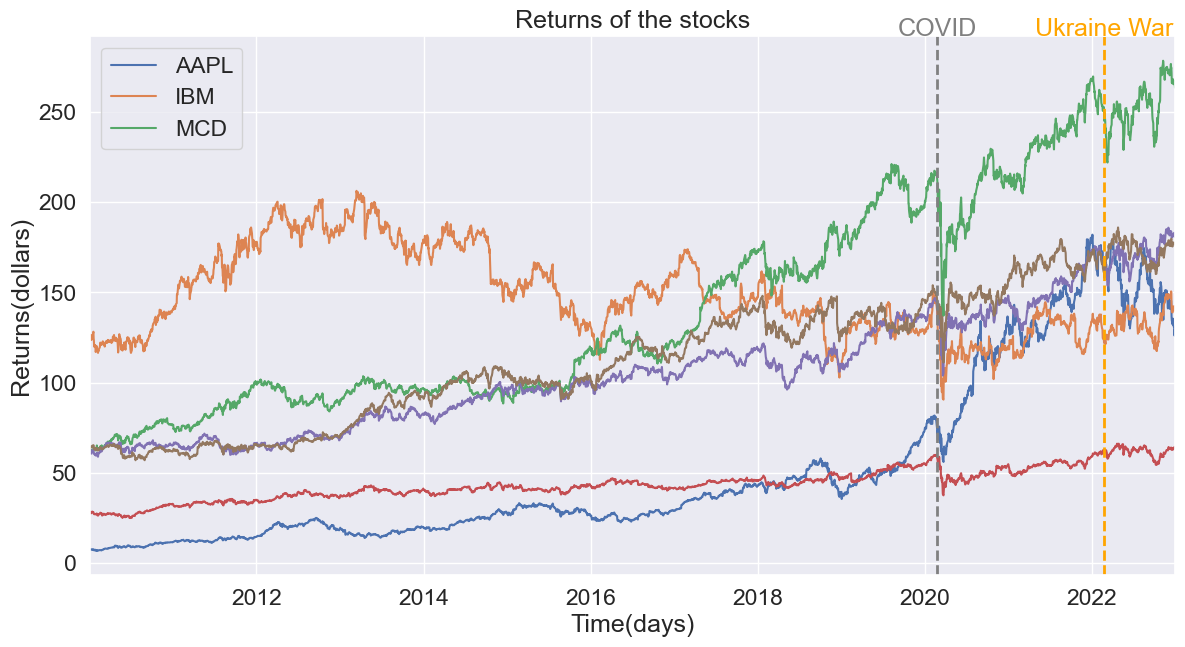

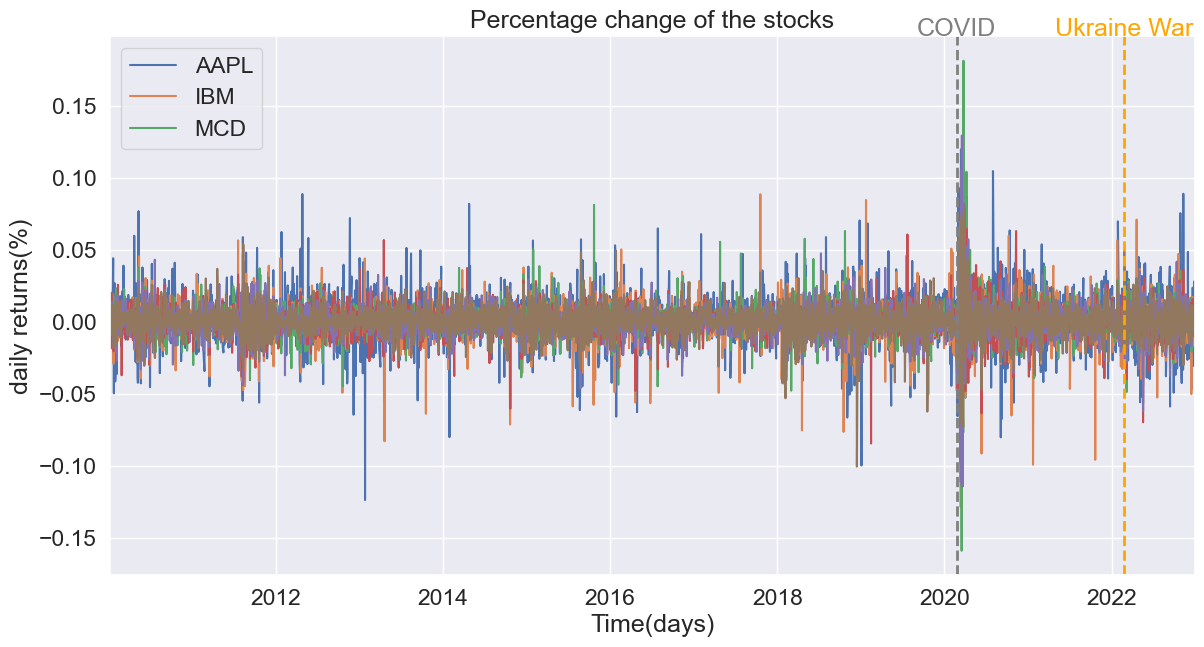

In [1]:
from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)

In [2]:
def plot_prices_volatilities_for_rw(stock_prices, real_volatility, real_volatility_startDate, real_volatility_endDate, rw_volatility, asset_name):
    '''
    Function to plot prices and volatilities for rolling window
    '''
     # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price(dollars)')
    ax1.legend(loc='upper left')

    # Plot real and rolling window volatilities
    ax2.plot(real_volatility_filtered, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(rw_volatility, label=f'RW {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs Rolling Window')
    ax2.set_xlabel('Time(days)')
    ax2.set_ylabel('Volatility(%)')
    ax2.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    
    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Adding vertical lines for specific events
    ax1.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
    ax1.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', lw=2)  # Ukraine War start

    # Adding vertical lines for specific events
    ax2.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
    ax2.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', lw=2)  # Ukraine War start

    # Show the plot
    plt.tight_layout()
    plt.show()

# Dictionary Initialization

In [3]:
prescientDict = {}
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
rwValues = []
rwMeanRegretValues = []
rwMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

# Covariance Predictors

PRESCIENT(GROUND TRUTH)

In [4]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

prescientDict = originalPrescientPredictor(uniformlyDistributedReturns)

    
# print the first 5 elements of the dictionary
for key in list(prescientDict.keys())[:5]:
    print(key, prescientDict[key])


print("dimension of the prescient dictionary: " + str(len(prescientDict)))

# print just the first key and value of the dictionary
print(list(prescientDict.keys())[0])
print(prescientDict[list(prescientDict.keys())[0]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[30])
print(prescientDict[list(prescientDict.keys())[30]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[60])
print(prescientDict[list(prescientDict.keys())[60]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[90])
print(prescientDict[list(prescientDict.keys())[90]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[120])
print(prescientDict[list(prescientDict.keys())[120]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[150])
print(prescientDict[list(prescientDict.keys())[150]])

2010-01-04 00:00:00           7         20990     21177     20468     21384     21018
7      0.000301  0.000114  0.000060  0.000044  0.000069  0.000056
20990  0.000114  0.000102  0.000041  0.000045  0.000053  0.000039
21177  0.000060  0.000041  0.000071  0.000036  0.000033  0.000015
20468  0.000044  0.000045  0.000036  0.000117  0.000050  0.000044
21384  0.000069  0.000053  0.000033  0.000050  0.000075  0.000030
21018  0.000056  0.000039  0.000015  0.000044  0.000030  0.000048
2010-01-05 00:00:00           7         20990     21177     20468     21384     21018
7      0.000301  0.000114  0.000060  0.000044  0.000069  0.000056
20990  0.000114  0.000102  0.000041  0.000045  0.000053  0.000039
21177  0.000060  0.000041  0.000071  0.000036  0.000033  0.000015
20468  0.000044  0.000045  0.000036  0.000117  0.000050  0.000044
21384  0.000069  0.000053  0.000033  0.000050  0.000075  0.000030
21018  0.000056  0.000039  0.000015  0.000044  0.000030  0.000048
2010-01-06 00:00:00           7     

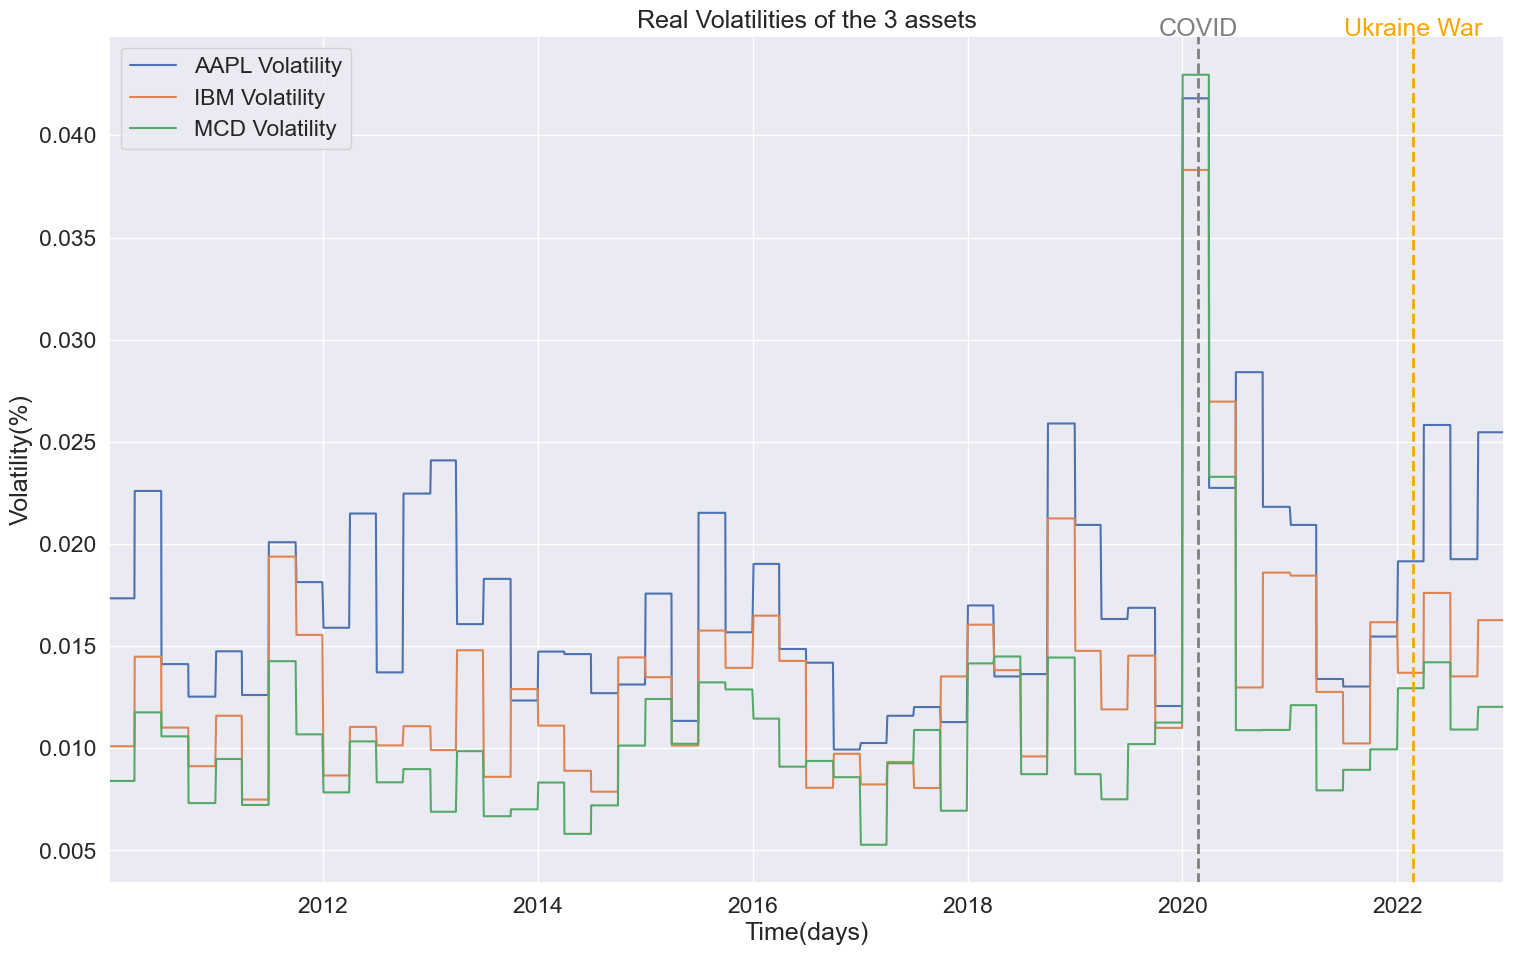

In [5]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

# now calculates/extract the real volatilities of the 3 assets
real_volatilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time(days)")
plt.ylabel("Volatility(%)")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_volatility_aapl.index[0], right=df_volatility_aapl.index[-1])
plt.show()

FOR THE RW PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS M(window memory) AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER. 
The best value for M has been found with the grid search method applied in the validation phase.

# Validation Phase for RW predictor

In [6]:
# this function is used to plot the performance of the RW predictor in terms of regret and log-likelihood

def plotLogLikelihoodPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue):
    '''
    plot the chart of the mean log-likelihood value
    '''
    rwMinValuesLogLikelihood = [] # this list will contain the rw values that have the max log-likelihood value
    plt.figure()
    plt.plot(rwValues, rwMeanlogLikelihoodValues)
    plt.title("Mean log-likelihood values of the RW predictor")
    plt.xlabel("RW memory")
    plt.ylabel("Mean log-likelihood")
    plt.title("Mean log-likelihood values of the RW predictor")

    # show also the loglikelihood value of the prescient predictor
    plt.axhline(y=prescientMeanlogLikelihoodValue, color='r', linestyle='-')
    plt.legend(["RW", "PRESCIENT"])

    # find the rw values that have the max log-likelihood value
    for j in range(len(rwMeanlogLikelihoodValues)):
        if rwMeanlogLikelihoodValues[j] == max(rwMeanlogLikelihoodValues):
            rwMinValuesLogLikelihood.append(rwValues[j])

    # these points show the interval of rw values that have the maximum log-likelihood value
    highlightsPoint1 = rwMinValuesLogLikelihood[0]
    plt.scatter(highlightsPoint1, max(rwMeanlogLikelihoodValues), color='r')
    #plt.text(highlightsPoint1, max(rwMeanlogLikelihoodValues), f' M: {highlightsPoint1:.1f}\n Log-likelihood: {max(rwMeanlogLikelihoodValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')

    highlightsPoint2 = rwMinValuesLogLikelihood[-1]
    plt.scatter(highlightsPoint2, max(rwMeanlogLikelihoodValues), color='r')
    #plt.text(highlightsPoint2, max(rwMeanlogLikelihoodValues), f' M: {highlightsPoint2:.1f}\n Log-likelihood: {max(rwMeanlogLikelihoodValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')
    
    # find the y value coordinate corresponding to the highlightPoint1LogLikelihood and highlightPoint2LogLikelihood
    highlightsPoint1Index = rwValues.index(highlightsPoint1)
    highlightsPoint2Index = rwValues.index(highlightsPoint2)

    highlightsPoint1Y = rwMeanlogLikelihoodValues[highlightsPoint1Index]
    highlightsPoint2Y = rwMeanlogLikelihoodValues[highlightsPoint2Index]

    print(f"rwMemory: {highlightsPoint1:.4f}\n Log-likelihood: {highlightsPoint1Y:.4f}")
    print(f"rwMemory: {highlightsPoint2:.4f}\n Log-likelihood: {highlightsPoint2Y:.4f}")

    # set the x-axis limits
    plt.xlim(left=10, right=600)

    plt.show()


def plotRegretPerformanceRW(rwValues, rwMeanRegretValues):
    '''
    plot the chart of the mean regret values
    '''

    rwMinValuesRegret = [] # this list will contain the rw values that have the min regret value
    plt.plot(rwValues, rwMeanRegretValues)
    plt.title("Mean regret values of the RW predictor")
    plt.xlabel("RW memory")
    plt.ylabel("Mean regret")
    plt.title("Mean regret values of the RW predictor")

    # find the rw values that have the min regret value
    for i in range(len(rwMeanRegretValues)):
        if rwMeanRegretValues[i] == min(rwMeanRegretValues):
            rwMinValuesRegret.append(rwValues[i])

    # these points show the interval of rw values that have the minimum regret value
    highlightsPoint1 = rwMinValuesRegret[0]
    plt.scatter(highlightsPoint1, min(rwMeanRegretValues), color='r')
    #plt.text(highlightsPoint1, min(rwMeanRegretValues), f' rwMemory: {highlightsPoint1:.1f} \n Regret: {min(rwMeanRegretValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')

    highlightsPoint2 = rwMinValuesRegret[-1]
    plt.scatter(highlightsPoint2, min(rwMeanRegretValues), color='r')
    #plt.text(highlightsPoint2, min(rwMeanRegretValues), f' rwMemory: {highlightsPoint2:.1f} \n Regret: {min(rwMeanRegretValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')
    
    # find the y value coordinate corresponding to the highlightPoint1Regret and highlightPoint2Regret
    highlightsPoint1Index = rwValues.index(highlightsPoint1)
    highlightsPoint2Index = rwValues.index(highlightsPoint2)

    highlightsPoint1Y = rwMeanRegretValues[highlightsPoint1Index]
    highlightsPoint2Y = rwMeanRegretValues[highlightsPoint2Index]

    print(f"rwMemory: {highlightsPoint1:.4f}\n Regret: {highlightsPoint1Y:.4f}")
    print(f"rwMemory: {highlightsPoint2:.4f}\n Regret: {highlightsPoint2Y:.4f}")

    # set the x-axis limits
    plt.xlim(left=10, right=600)

    plt.show()

In [7]:
def plotPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, rwMeanRegretValues):
    '''
    plotting the results of the RW predictor expressed in terms of loglikelihood and regret on a single chart
    '''

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the mean log-likelihood values for RW
    color = 'tab:blue'
    ax1.set_xlabel('RW values')
    ax1.set_ylabel('Mean log-likelihood', color=color)
    ax1.plot(rwValues, rwMeanlogLikelihoodValues, color=color, label='Loglikelihood RW')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot the loglikelihood value of the prescient predictor
    ax1.axhline(y=prescientMeanlogLikelihoodValue, color='tab:green', linestyle='-', label='Loglikelihood PRESCIENT')

    # Highlight the maximum log-likelihood points
    max_log_likelihood = max(rwMeanlogLikelihoodValues)
    max_points = [beta for beta, value in zip(rwValues, rwMeanlogLikelihoodValues) if value == max_log_likelihood]

    # take just the first and last element of the list
    max_points = [max_points[0], max_points[-1]]

    # scatter the points by writing the memory value and the loglikelihood value on the chart
    for point in max_points:
        ax1.scatter(point, max_log_likelihood, color='green')
        plt.text(point, max_log_likelihood, f' x: {point:.0f}\n y: {max_log_likelihood:.1f}', fontsize=9, color='green', ha='center', va='bottom')

    # Add a second y-axis for the regret values
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Mean regret', color=color)  
    ax2.plot(rwValues, rwMeanRegretValues, color=color, label='Regret RW')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight the minimum regret points
    min_regret = min(rwMeanRegretValues)
    min_points = [beta for beta, value in zip(rwValues, rwMeanRegretValues) if value == min_regret]

    # take just the first and last element of the list
    min_points = [min_points[0], min_points[-1]]

    # scatter the points by writing the beta value and the regret value on the chart
    for point in min_points:
        ax2.scatter(point, min_regret, color='red')
        plt.text(point, min_regret, f' x: {point:.0f}\n y: {min_regret:.1f}', fontsize=9, color='red', ha='center', va='bottom')

    print("max_points: " + str(max_points))
    print("min_points: " + str(min_points))

    # Create the legend, which combines both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Add title
    plt.title("Performance of RW for different M values")

    # Set the x-axis limits
    ax1.set_xlim(left=rwValues[0], right=rwValues[-1])

    fig.tight_layout()  # to ensure the right y-label is not slightly clipped
    plt.show()


In [8]:
# Loop through rw_memory values

def rwValidationPhase(rw_memory, startingDate, endingDate, rw_size_increment, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the RW predictor; it's used to find the best memory size of the window for the rw predictor.
    Grid search is used and the performance of the M hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while rw_memory < 700:

        rwDict = rolling_window(validationDataWithPercentageChange, rw_memory) 

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
            
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["RW", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [rwDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})
            

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            if names[i] == "PRESCIENT":
                returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
            
            else:
                returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]


        # plot the log-likelihood values of the prescient predictor
        if prescientAlreadyPrinted == False:    
            plt.figure(figsize=(14, 7))
            plt.plot(daily_log_likelihoods['PRESCIENT'].index, daily_log_likelihoods['PRESCIENT'].values, label='Prescient Daily Log-Likelihood', marker='x', linestyle='-', color='green')
            plt.title(f'Daily Log-Likelihood of the Prescient Predictor')
            plt.xlabel('Date(days)')
            plt.ylabel('Value')
            plt.legend()
            plt.show()
            prescientAlreadyPrinted = True

            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                rwMeanRegretValues.append(regretMetrics[0])

        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()
        prescientMeanlogLikelihoodValues = []

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":
                # save the log-likelihood mean values to plot a chart
                rwMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
            
            if name == "PRESCIENT":
            # i'm writing the prescient predictor only once, because it's the same for every rw_memory value

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
        
        # save the rw value to plot a chart
        rwValues.append(rw_memory)

        # Increment beta
        rw_memory += rw_size_increment

    # return the fundamental values to plot the charts
    return rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues

In [9]:
# first of all define the starting and ending date for the validation phase: take the first and the last date of the validation dataset

startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

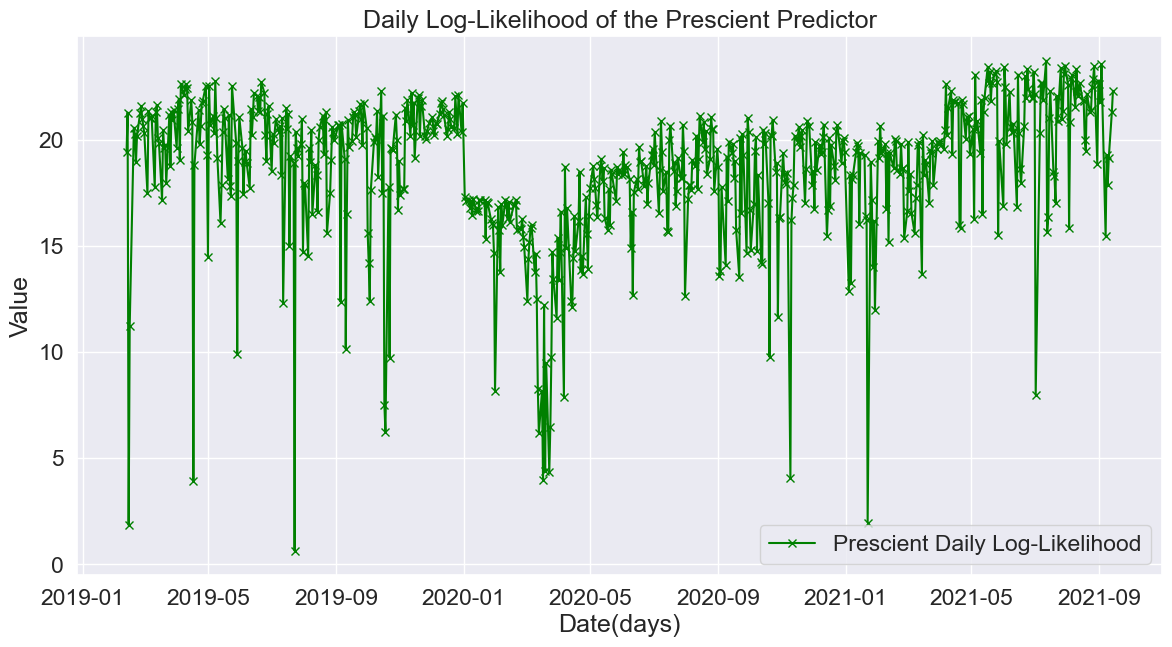

rwMemory: 40.0000
 Log-likelihood: 17.5000
rwMemory: 140.0000
 Log-likelihood: 17.5000


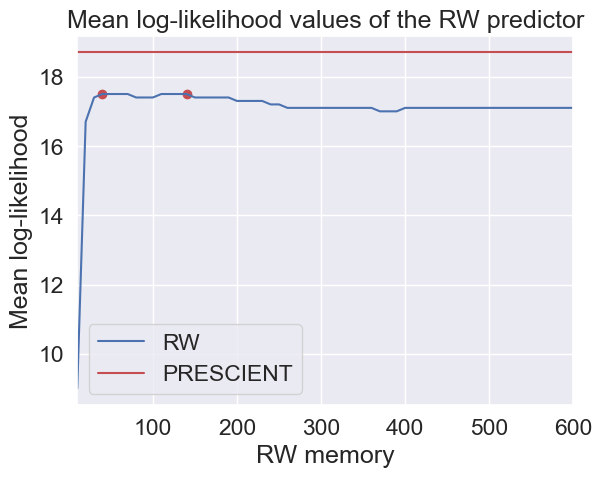

rwMemory: 40.0000
 Regret: 1.2000
rwMemory: 70.0000
 Regret: 1.2000


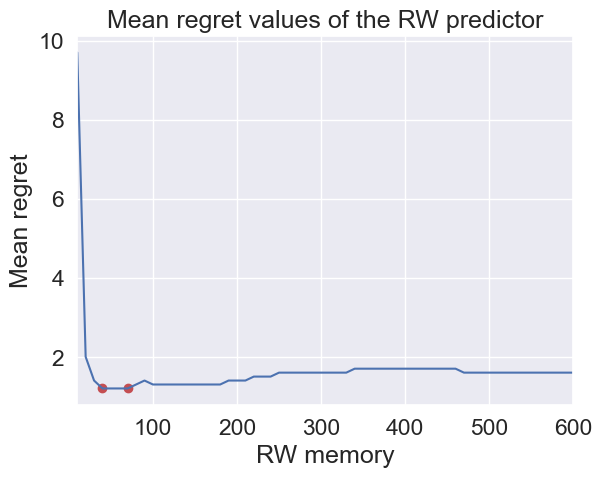

max_points: [40, 140]
min_points: [40, 70]


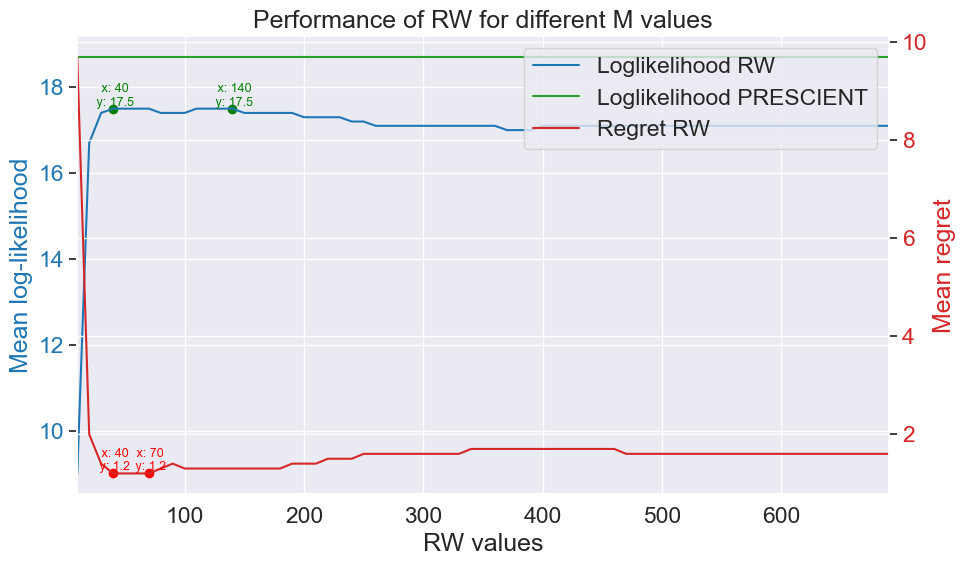

In [10]:
# grid search run for the RW predictor
rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = rwValidationPhase(10, startingValidationDate, endingValidationDate, 10, prescientAlreadyPrinted)

# plot the performance of the RW predictor in terms of log-likelihood
plotLogLikelihoodPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the RW predictor in terms of regret
plotRegretPerformanceRW(rwValues, rwMeanRegretValues)

# plot the performance of the RW predictor in terms of log-likelihood and regret
plotPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, rwMeanRegretValues)

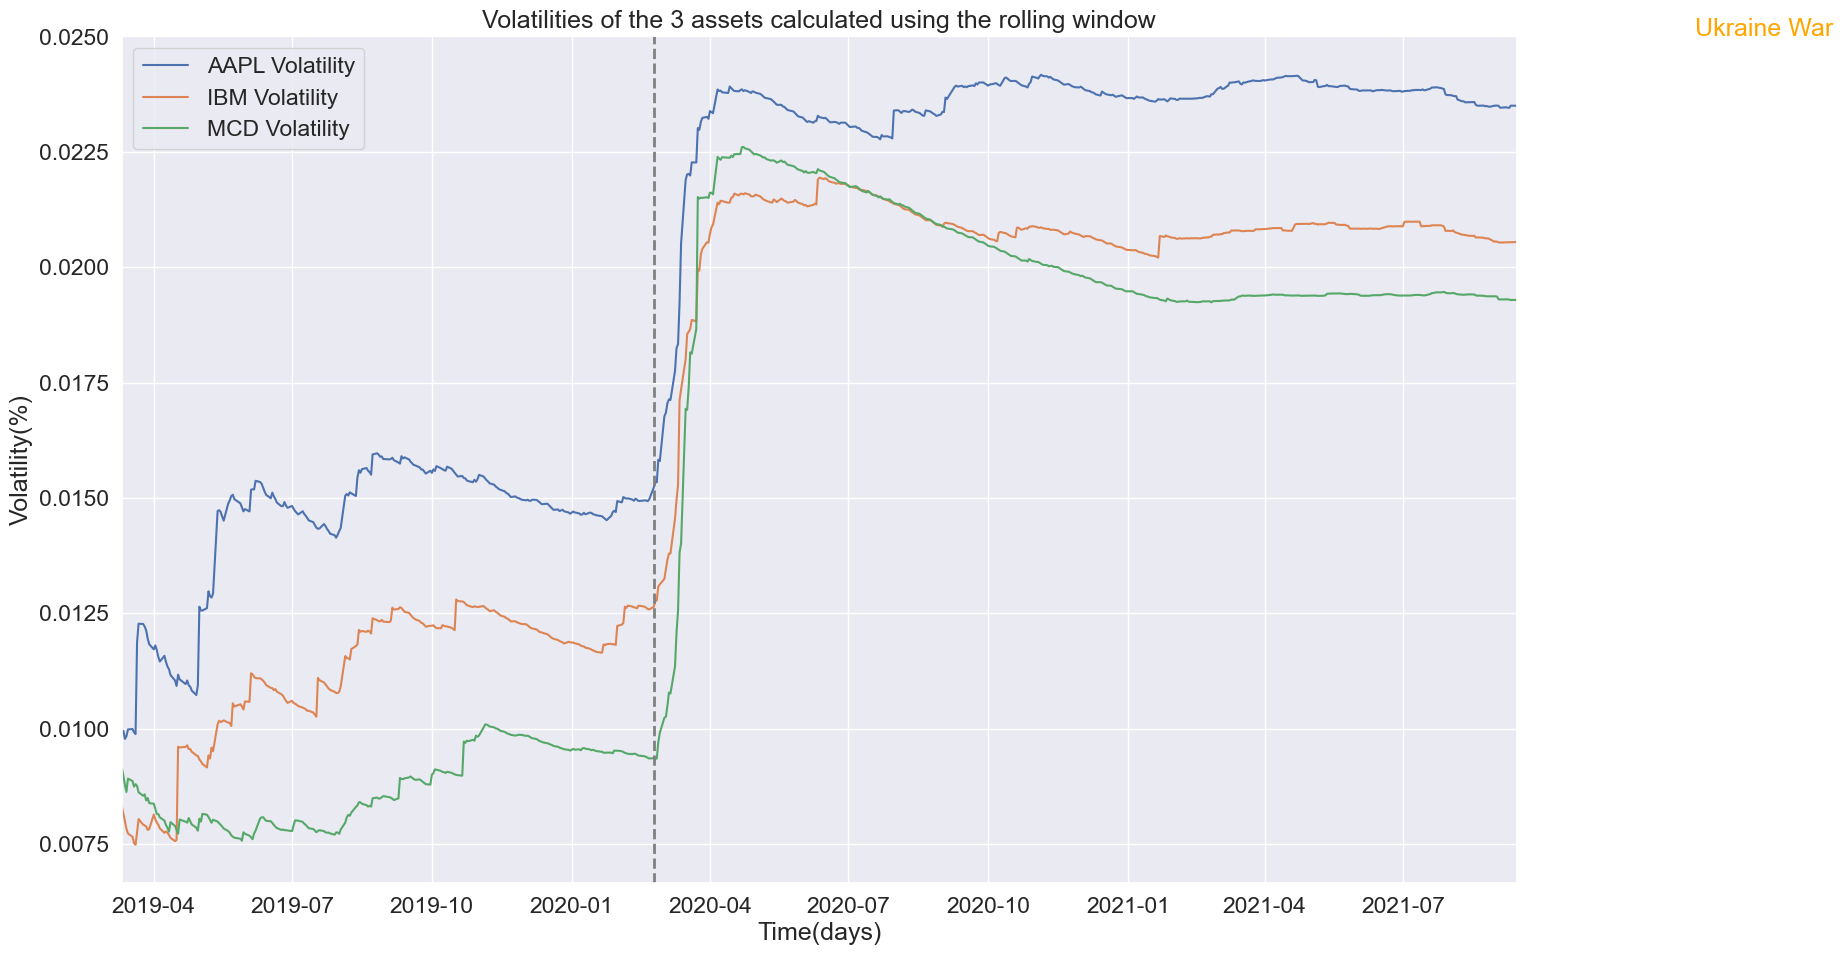

In [11]:
# prepare the date for the test phase

startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best memory size for the RW predictor(the one found in the validation phase)

rw_memory = 500

rwDict = rolling_window(validationDataWithPercentageChange, rw_memory)

rw_volatilities = {}

for date, cov_matrix in rwDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    rw_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now rw_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the rwDict dictionary(the timestamp)
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingValidationDate)
real_volatility_endDate = pd.to_datetime(endingValidationDate)

# filter the dictionary
rw_volatilities = {k: v for k, v in rw_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
# now separate the real volatilities of the 3 assets in 3 different dataframes
rw_volatility_dict_aapl = {}
rw_volatility_dict_ibm = {}
rw_volatility_dict_mcd = {}

for date, volatilities in rw_volatilities.items():
    rw_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    rw_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    rw_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_rw_volatility_aapl = pd.DataFrame(list(rw_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_rw_volatility_ibm = pd.DataFrame(list(rw_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_rw_volatility_mcd = pd.DataFrame(list(rw_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_rw_volatility_aapl.set_index('Date', inplace=True)
df_rw_volatility_ibm.set_index('Date', inplace=True)
df_rw_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_rw_volatility_aapl, label='AAPL Volatility')
plt.plot(df_rw_volatility_ibm, label='IBM Volatility')
plt.plot(df_rw_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the rolling window")
plt.xlabel("Time(days)")
plt.ylabel("Volatility(%)")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
#plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_rw_volatility_aapl.index[0], right=df_rw_volatility_aapl.index[-1])
plt.show()

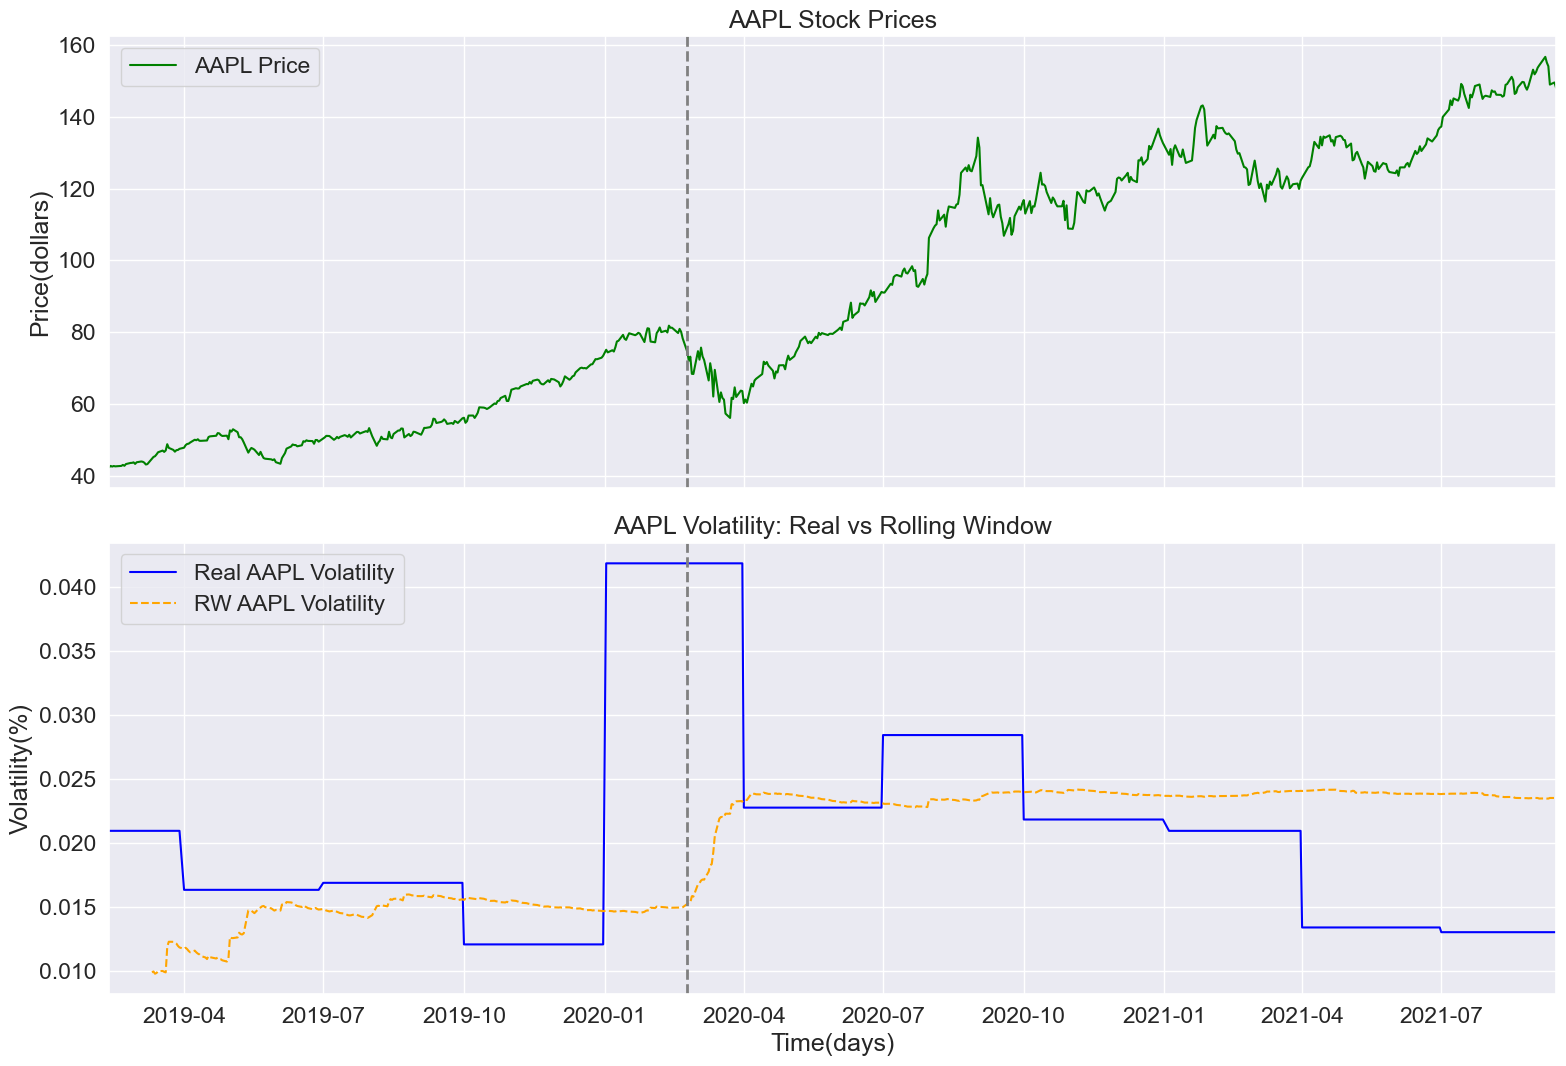

In [12]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')

# Test Phase for RW predictor

In this test phase i will use the best value for rw_memory found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

to be more fair in the measure of the model performance i will remove the first 19 days from every predictor dict minus the rolling window predictor dict.

the timestamp of the first element of the rolling window dictionary: 2021-10-12 00:00:00
the first element of the rolling window dictionary:           7         20990     21177     20468     21384     21018
7      0.000148  0.000045  0.000067  0.000064  0.000064  0.000045
20990  0.000045  0.000119  0.000036  0.000035  0.000008  0.000005
21177  0.000067  0.000036  0.000066  0.000030  0.000032  0.000022
20468  0.000064  0.000035  0.000030  0.000058  0.000049  0.000017
21384  0.000064  0.000008  0.000032  0.000049  0.000069  0.000025
21018  0.000045  0.000005  0.000022  0.000017  0.000025  0.000046


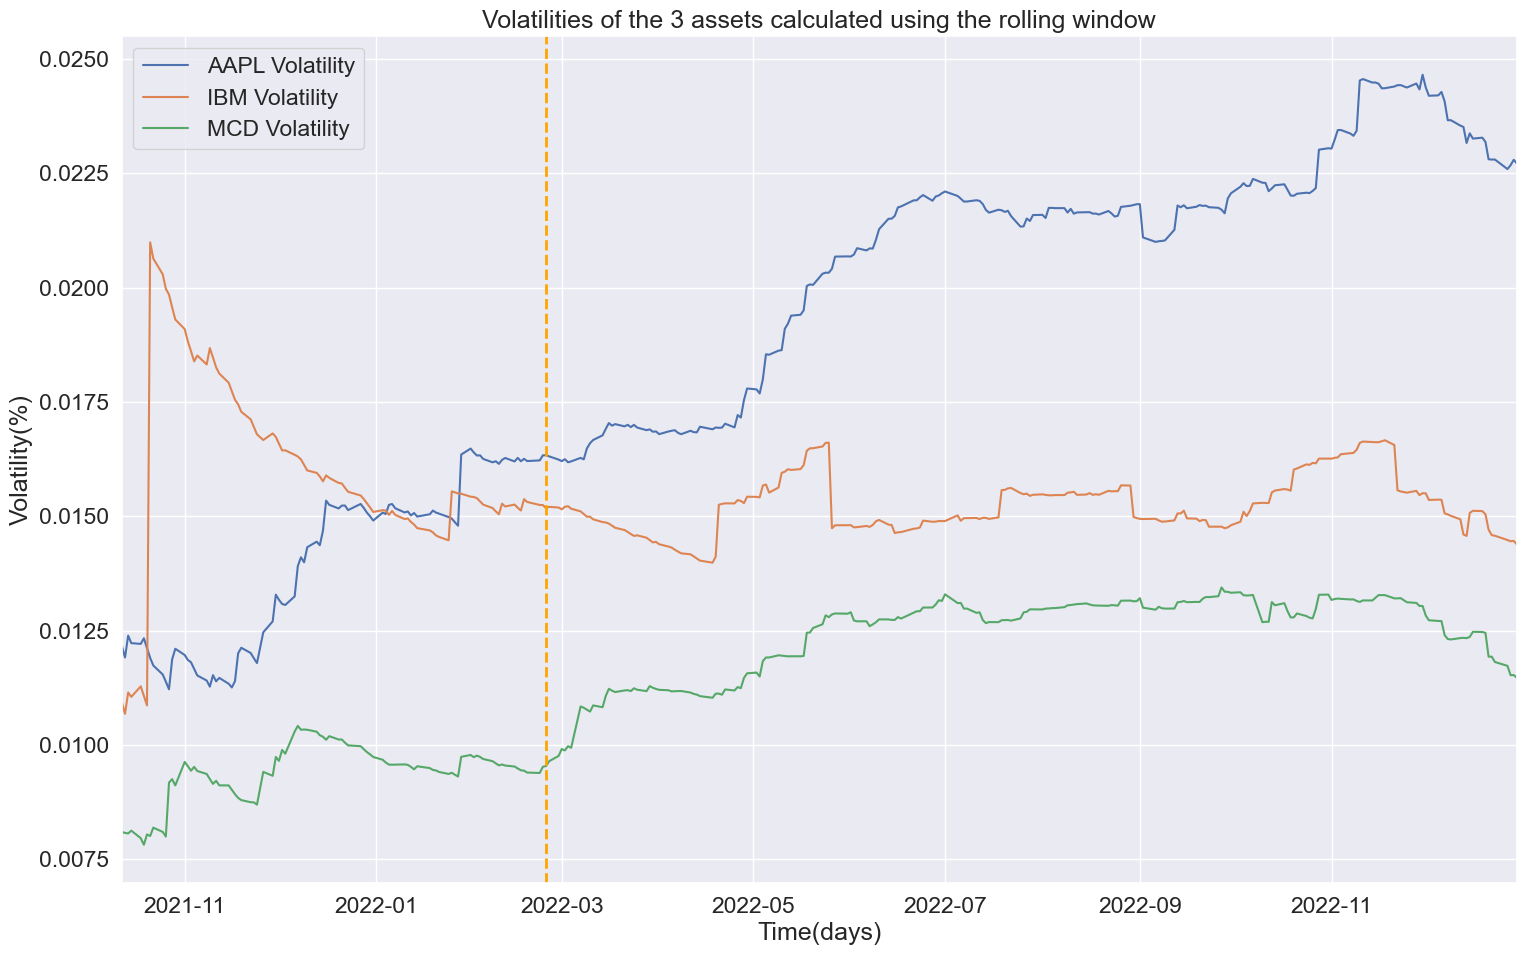

In [13]:
# prepare the date for the test phase

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best memory size for the RW predictor(the one found in the validation phase)

rw_memory = 150

rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

print("the timestamp of the first element of the rolling window dictionary: " + str(list(rwDict.keys())[0]))
print("the first element of the rolling window dictionary: " + str(rwDict[list(rwDict.keys())[0]]))

rw_volatilities = {}

for date, cov_matrix in rwDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    rw_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now rw_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the rwDict dictionary(the timestamp)
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# filter the dictionary
rw_volatilities = {k: v for k, v in rw_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
# now separate the real volatilities of the 3 assets in 3 different dataframes
rw_volatility_dict_aapl = {}
rw_volatility_dict_ibm = {}
rw_volatility_dict_mcd = {}

for date, volatilities in rw_volatilities.items():
    rw_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    rw_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    rw_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_rw_volatility_aapl = pd.DataFrame(list(rw_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_rw_volatility_ibm = pd.DataFrame(list(rw_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_rw_volatility_mcd = pd.DataFrame(list(rw_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_rw_volatility_aapl.set_index('Date', inplace=True)
df_rw_volatility_ibm.set_index('Date', inplace=True)
df_rw_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_rw_volatility_aapl, label='AAPL Volatility')
plt.plot(df_rw_volatility_ibm, label='IBM Volatility')
plt.plot(df_rw_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the rolling window")
plt.xlabel("Time(days)")
plt.ylabel("Volatility(%)")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_rw_volatility_aapl.index[0], right=df_rw_volatility_aapl.index[-1])
plt.show()

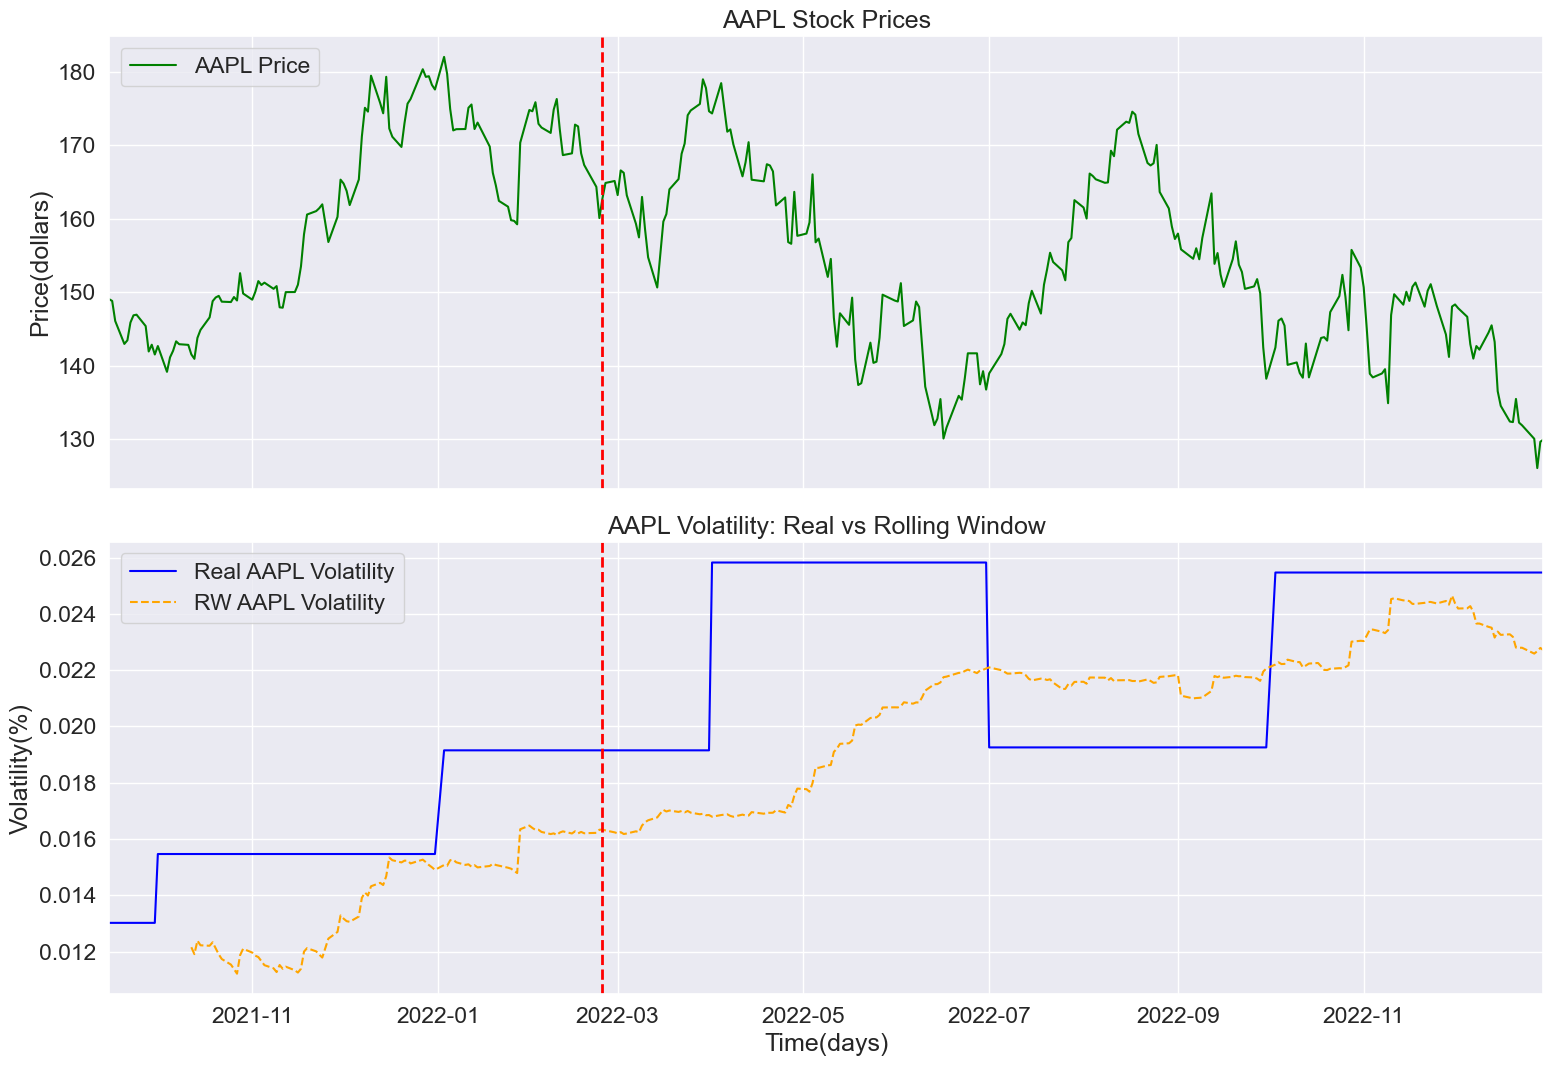

In [14]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')

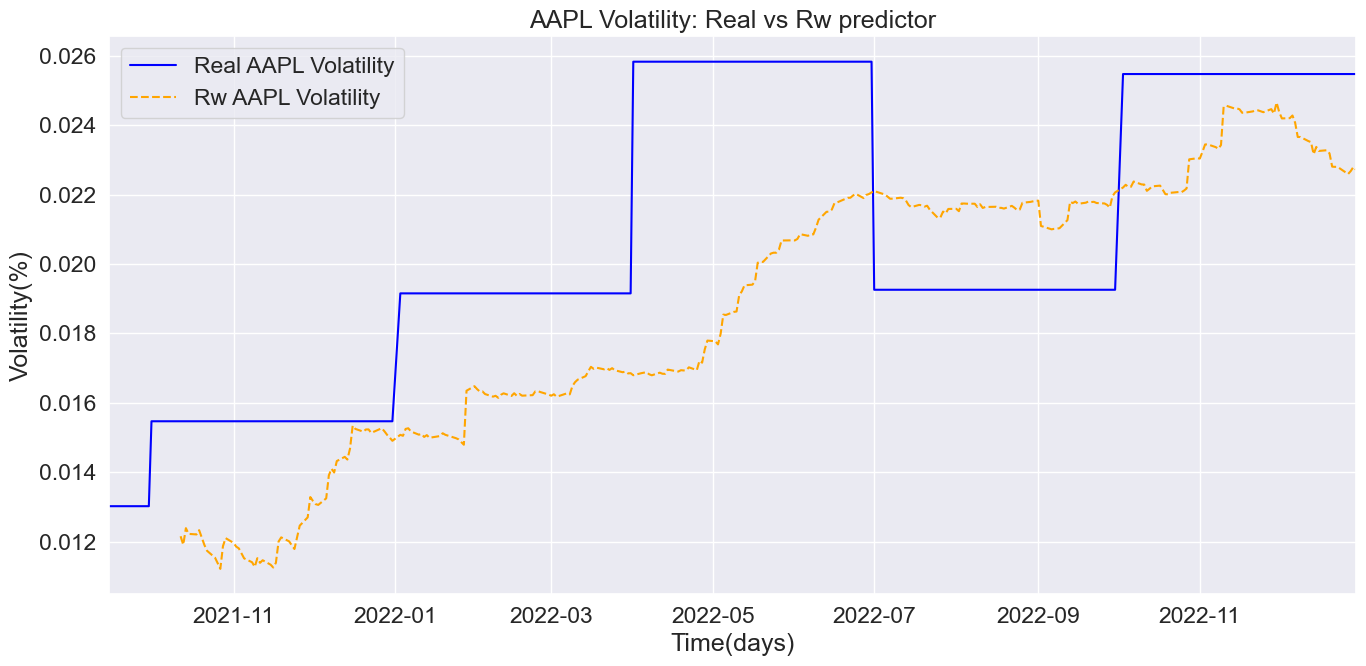

In [15]:
####################### code for test ####################################

def plot_prices_volatilities_for_ewAndRWTest(real_volatility, real_volatility_startDate, real_volatility_endDate, hybrid_volatility, asset_name):
    # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]

    plt.figure(figsize=(14, 7))

    # Plot real and rolling window volatilities
    plt.plot(real_volatility_filtered, label='Real AAPL Volatility', color='blue')
    plt.plot(hybrid_volatility, label='Rw AAPL Volatility', color='orange', linestyle='--')
    plt.title('AAPL Volatility: Real vs Rw predictor')
    plt.xlabel('Time(days)')
    plt.ylabel('Volatility(%)')
    plt.legend(loc='upper left')


    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Show the plot
    plt.tight_layout()
    plt.show()


# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewAndRWTest(df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')
##########################################################################

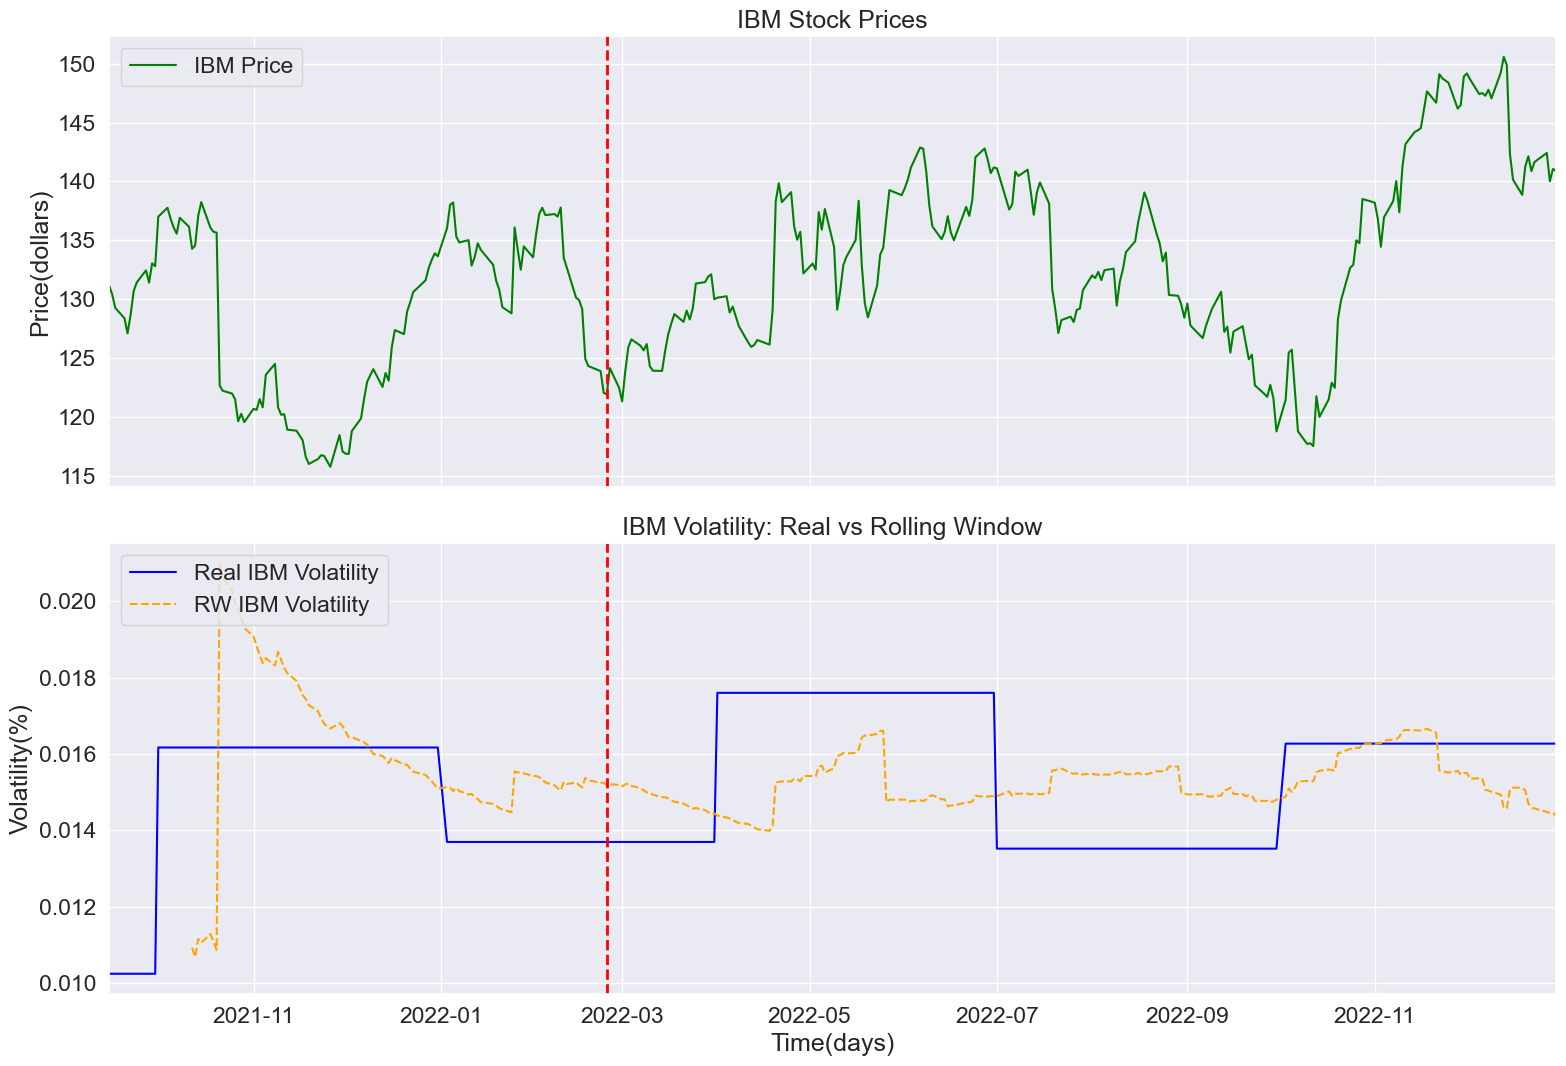

In [16]:
plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_rw_volatility_ibm['IBM Volatility'], 'IBM')

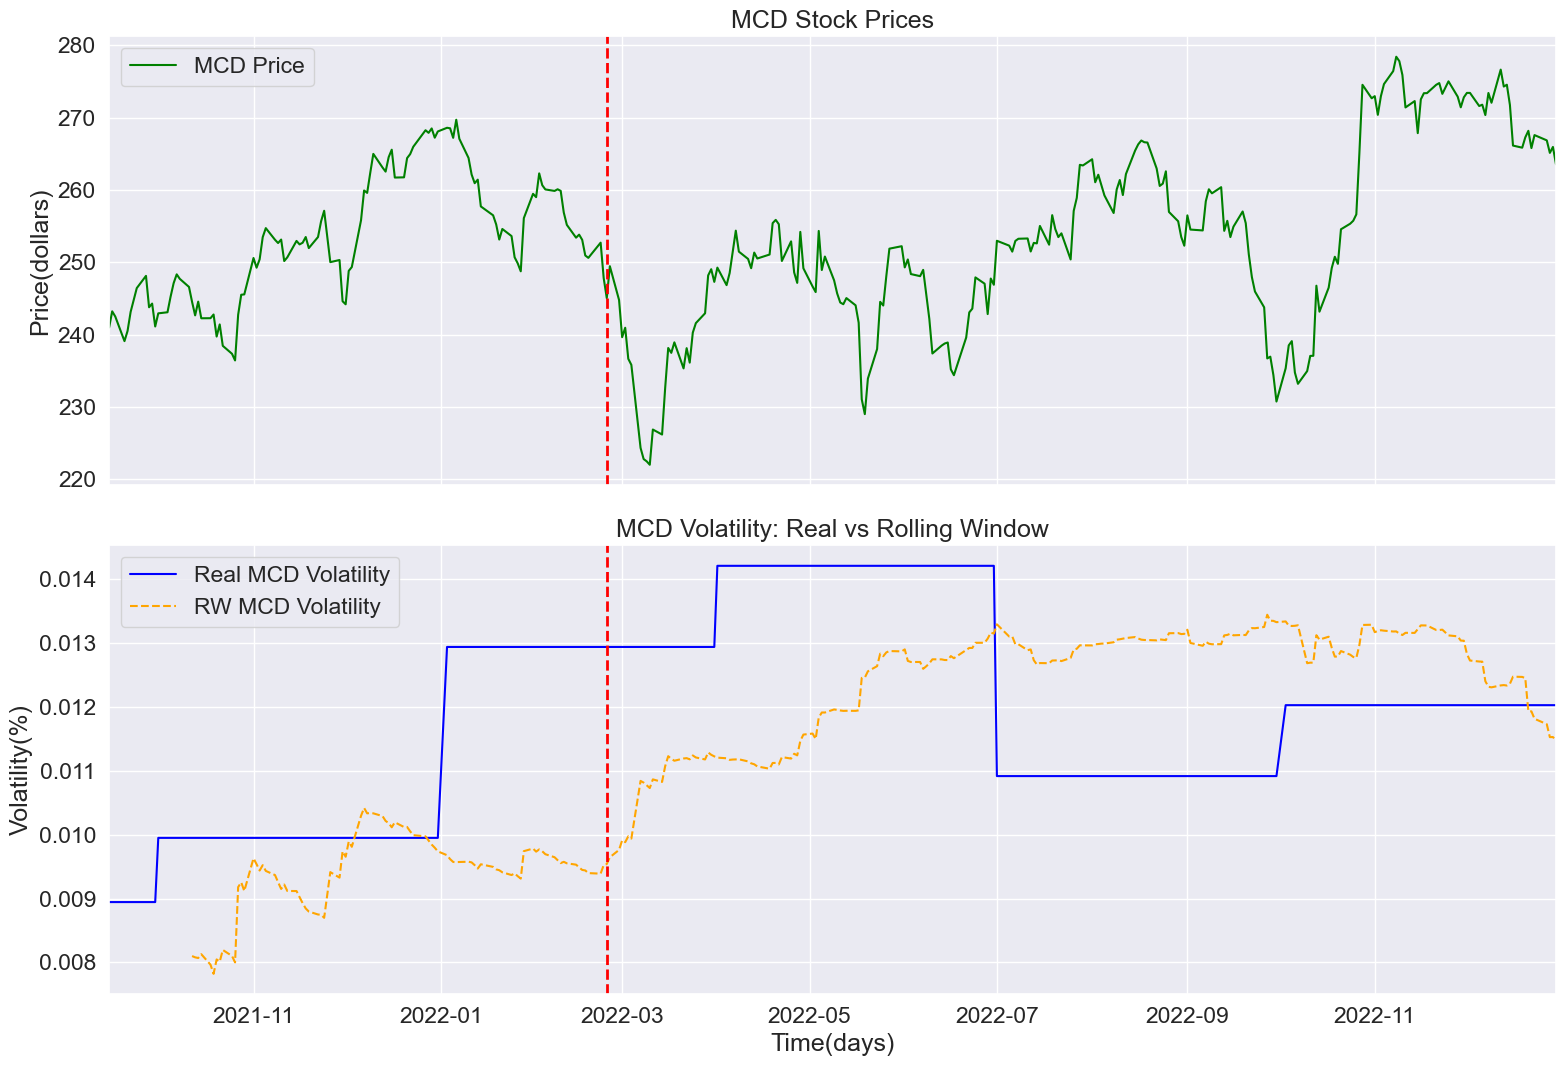

In [17]:
plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_rw_volatility_mcd['MCD Volatility'], 'MCD')

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00
dets shape:  (307, 1, 1)
matrixProduct shape:  (307, 1, 1)
results saved in detsAndMatrixProduct.csv
dets shape:  (307, 1, 1)
matrixProduct shape:  (307, 1, 1)
results saved in detsAndMatrixProduct.csv


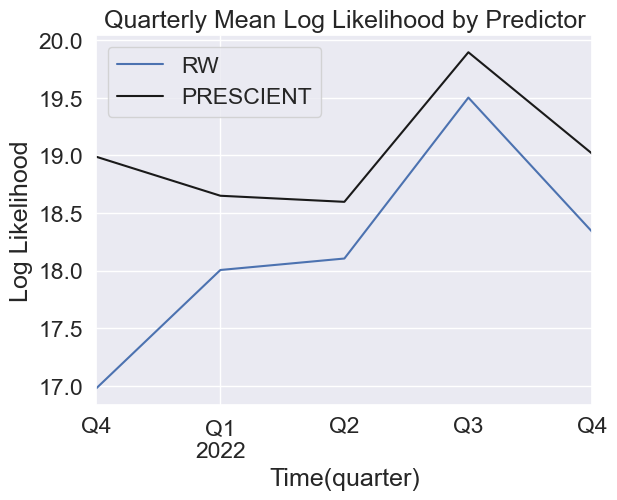



meanRegret: 0.800
stdRegret: 0.600
maxRegret: 2.000


meanLoglikelihoodRW: 18.200
stdLoglikelihoodRW: 0.800
maxLoglikelihoodRW: 19.500


meanLoglikelihoodPRESCIENT: 19.000
stdLoglikelihoodPRESCIENT: 0.500
maxLoglikelihoodPRESCIENT: 19.900
lenght of prescientDict:  308
lenght of rwDict:  308
lenght of predictorDict:  308

RW RMSE
mean: 0.0003071972
std: 0.0001748831
max: 0.0006498021
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.00015658383181986883, Timestamp('2022-03-31 00:00:00'): 0.0002513333796327369, Timestamp('2022-06-30 00:00:00'): 0.0006498020973472836, Timestamp('2022-10-02 00:00:00'): 0.0002237726265020434, Timestamp('2022-12-29 00:00:00'): 0.00025449398993752307}


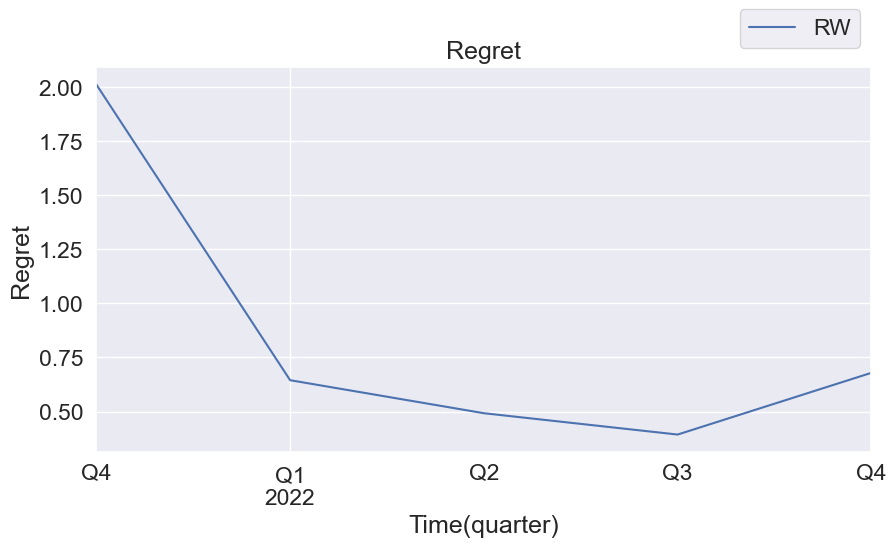

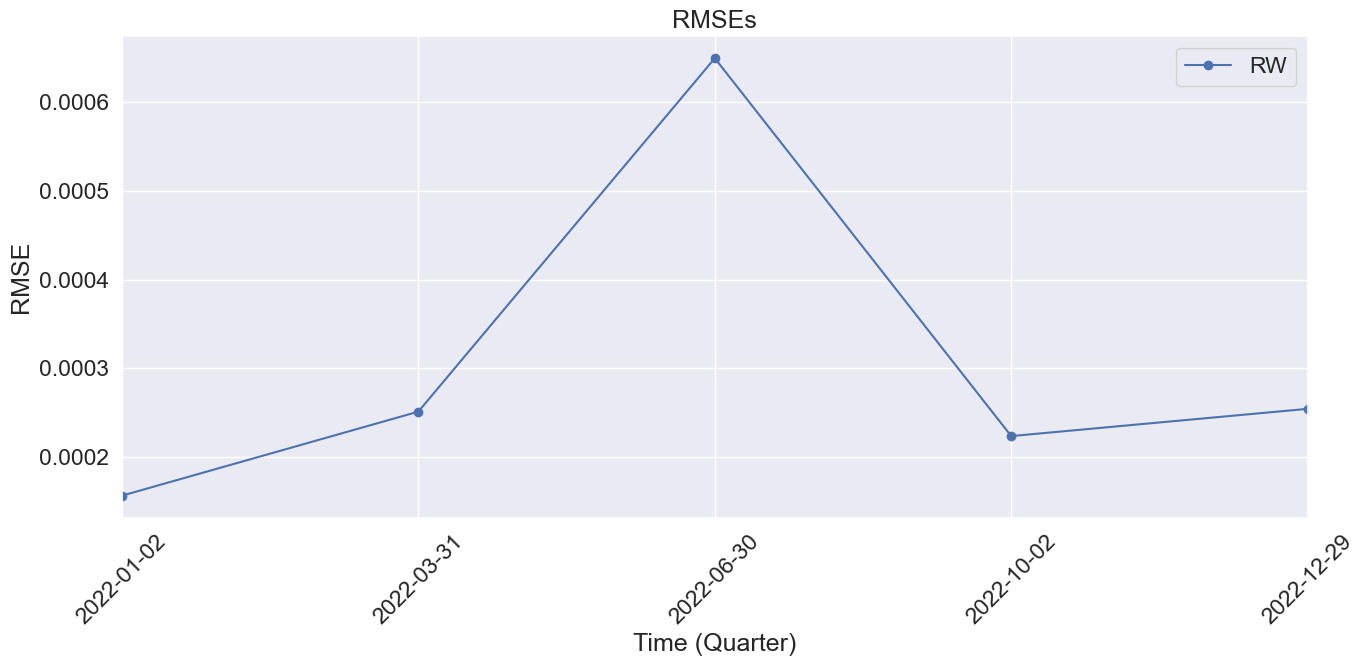

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_rw:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.0027819402595157163, Timestamp('2022-03-31 00:00:00'): 0.0031550192784730773, Timestamp('2022-06-30 00:00:00'): 0.0067812256685800005, Timestamp('2022-10-02 00:00:00'): 0.0024097731678305204, Timestamp('2022-12-29 00:00:00'): 0.0024068825254007133}


RMSEs for AAPL
mean: 0.0035069682
std: 0.0016603807
max: 0.0067812257


RMSEs for IBM
mean: 0.0018088209
std: 0.0006179116
max: 0.0026010880


RMSEs for MCD
mean: 0.0018403446
std: 0.0007989069
max: 0.0029827975


In [18]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["RW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [rwDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDict = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDict = {k: prescientDict[k] for k in list(prescientDict)[19:]}
predictors[1] = prescientDict

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        rw: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood_for_test(returns_temp, Sigmas_temp), index=times) # TODO: after test rewrite the line of code to use the log_likelihood function

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        rw: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        rwMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of rwDict: ", len(rwDict))
        
for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        print("lenght of predictorDict: ", len(predictorDict))
        RMSEs = RMSE(testDataWithPercentageChange, predictorDict, prescientDict, start_date)
        print("\n" + names[i] + " RMSE")

        # Calculate mean, standard deviation, and max value of the RMSEs
        mean_rmse = np.mean(list(RMSEs.values()))
        std_rmse = np.std(list(RMSEs.values()))
        max_rmse = np.max(list(RMSEs.values()))

        print(f"mean: {mean_rmse:.10f}")
        print(f"std: {std_rmse:.10f}")
        print(f"max: {max_rmse:.10f}")


print("lenght of rmses: ", len(RMSEs))
print("values of rmses: ", RMSEs)

# Convert Timestamps to strings for plotting
timestamps = [ts.strftime('%Y-%m-%d') for ts in RMSEs.keys()]
rmse_values = list(RMSEs.values())

# Plot the RMSEs with improved formatting
plt.figure(figsize=(14, 7))  # Increase the figure size for better readability
plt.plot(timestamps, rmse_values, marker='o', linestyle='-', label='RW', color='b')

# Set the x-axis to only include the dates from the dictionary
plt.xticks(timestamps, rotation=45)

# Remove the left margin
plt.margins(x=0)

# Add labels and title
plt.xlabel('Time (Quarter)')
plt.ylabel('RMSE')
plt.title('RMSEs')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDict.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_rw_filtered = {k: v for k, v in rw_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_rw_filtered = {k: v for k, v in rw_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_rw_filtered = {k: v for k, v in rw_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_rw: ", len(volatility_dict_aapl_rw_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEs_aapl_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_aapl_rw_filtered, start_date)
RMSEs_ibm_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_ibm_filtered, volatility_dict_ibm_rw_filtered, start_date)
RMSEs_mcd_dict = RMSEforSingleVolatility(testDataWithPercentageChange, volatility_dict_mcd_filtered, volatility_dict_mcd_rw_filtered, start_date)

print("lenght of RMSEs_aapl: ", len(RMSEs_aapl_dict))
print("values of RMSEs_aapl: ", RMSEs_aapl_dict)

print("\n")
print("RMSEs for AAPL")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_aapl = np.mean(list(RMSEs_aapl_dict.values()))
std_rmse_aapl = np.std(list(RMSEs_aapl_dict.values()))
max_rmse_aapl = np.max(list(RMSEs_aapl_dict.values()))

print(f"mean: {mean_rmse_aapl:.10f}")
print(f"std: {std_rmse_aapl:.10f}")
print(f"max: {max_rmse_aapl:.10f}")

print("\n")
print("RMSEs for IBM")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_ibm = np.mean(list(RMSEs_ibm_dict.values()))
std_rmse_ibm = np.std(list(RMSEs_ibm_dict.values()))
max_rmse_ibm = np.max(list(RMSEs_ibm_dict.values()))

print(f"mean: {mean_rmse_ibm:.10f}")
print(f"std: {std_rmse_ibm:.10f}")
print(f"max: {max_rmse_ibm:.10f}")

print("\n")
print("RMSEs for MCD")

# Calculate mean, standard deviation, and max value of the RMSEs. the RMSEs are dictionaries whose key is the timestamp and the value is the rmse value
mean_rmse_mcd = np.mean(list(RMSEs_mcd_dict.values()))
std_rmse_mcd = np.std(list(RMSEs_mcd_dict.values()))
max_rmse_mcd = np.max(list(RMSEs_mcd_dict.values()))

print(f"mean: {mean_rmse_mcd:.10f}")
print(f"std: {std_rmse_mcd:.10f}")
print(f"max: {max_rmse_mcd:.10f}")